In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pandas as pd
import matplotlib.pyplot as plt
import calendar
from prettytable import PrettyTable

In [3]:
spark = SparkSession.builder.appName("FlightPriceEDA").getOrCreate() 
spark.conf.set("spark.sql.legacy.timeParserPolicy", "CORRECTED")
spark.sparkContext

<SparkContext master=yarn appName=PySparkShell>

In [13]:
price_df = spark.read.parquet("gs://msca-bdp-student-gcs/Group7_Final_Project/flight_pricing/preprocessed_prices.parquet", 
                                     header=True, inferSchema=True)

In [14]:
price_df.printSchema()

root
 |-- search_date: date (nullable = true)
 |-- flight_date: date (nullable = true)
 |-- origin: string (nullable = true)
 |-- destination: string (nullable = true)
 |-- fare_basis_code: string (nullable = true)
 |-- travel_duration: string (nullable = true)
 |-- elapsed_days: integer (nullable = true)
 |-- is_basic_economy: boolean (nullable = true)
 |-- is_refundable: boolean (nullable = true)
 |-- is_nonstop: boolean (nullable = true)
 |-- base_fare: double (nullable = true)
 |-- total_fare: double (nullable = true)
 |-- seats_remaining: integer (nullable = true)
 |-- total_distance: integer (nullable = true)
 |-- departure_time: string (nullable = true)
 |-- arrival_time: string (nullable = true)
 |-- airline_name: string (nullable = true)
 |-- airline_code: string (nullable = true)
 |-- equipment_description: string (nullable = true)
 |-- distance: string (nullable = true)
 |-- cabin_code: string (nullable = true)
 |-- days_until_flight: integer (nullable = true)
 |-- flight_ye

Identifying missing data

In [15]:
total_rows = price_df.count()
price_df_no_missing = price_df.dropna()
total_rows_no_missing = price_df_no_missing.count()
missing_rows = total_rows - total_rows_no_missing

print("Total Rows:", total_rows)
print("Total Rows with Missing Values:", missing_rows)
print("Total Rows after Missing Values Removed:", total_rows_no_missing)

Total Rows: 82138753
Total Rows with Missing Values: 7384463
Total Rows after Missing Values Removed: 74754290


**General Overview:**
* What are the total number of records in this dataset?
* How are the total fares distributed?
* How do the numerical features correlate to the total fare?
* What is the distribution of boolean columns?
* What are the most popular origin and destination airports?

In [16]:
price_df.count()

82138753

In [17]:
price_df = price_df.withColumn("normalized_fare", col("total_fare") / col("total_distance"))

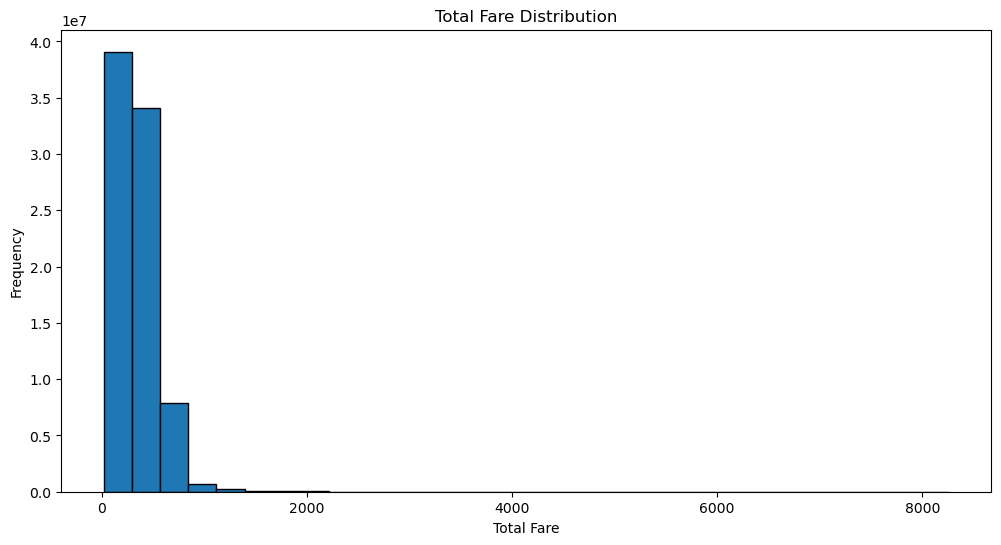

In [18]:
result_df = (price_df.select('total_fare')
                     .toPandas())

plt.figure(figsize=(12, 6))
plt.hist(result_df['total_fare'], bins=30, edgecolor='black')
plt.title('Total Fare Distribution')
plt.xlabel('Total Fare')
plt.ylabel('Frequency')
plt.show()

The distribution looks heavily skewed to the right. Let's identify and remove extrememly expensive fares.

In [22]:
count_expensive_rows = price_df.filter(col('total_fare') > 2000).count()

print(f'Number of rows where total_fare > 2000: {count_expensive_rows}')

Number of rows where total_fare > 2000: 26314


Less than 0.05% of rows have fares greater than $2000, so we can safely drop them.

In [23]:
price_df = price_df.filter(col('total_fare') <= 2000)

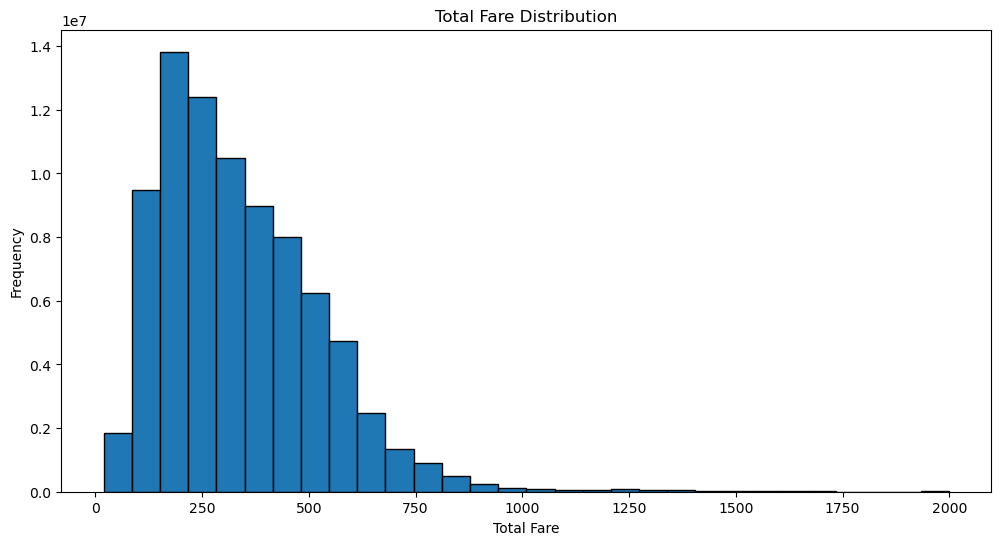

In [24]:
result_df = (price_df.select('total_fare')
                     .toPandas())

plt.figure(figsize=(12, 6))
plt.hist(result_df['total_fare'], bins=30, edgecolor='black')
plt.title('Total Fare Distribution')
plt.xlabel('Total Fare')
plt.ylabel('Frequency')
plt.show()

Our distribution still skews to the right. However, dropping rows containing these heavy outliers will lead to a more accurate predictive model.

In [25]:
nonnumeric_columns = ["search_date",
                      "flight_date",
                      "origin", 
                      "destination", 
                      "fare_basis_code", 
                      "travel_duration", 
                      "distance",
                      "departure_time",
                      "initial_departure_datetime",
                      "final_arrival_datetime",
                      "arrival_time",
                      "airline_name",
                      "airline_code",
                      "airline_category",
                      "cabin_code_category",
                      "equipment_description",
                      "cabin_code",
                      "day_of_week",
                      "class",
                      "class_category"]

numeric_df = price_df.withColumn("is_basic_economy", col("is_basic_economy").cast("int"))
numeric_df = numeric_df.withColumn("is_refundable", col("is_refundable").cast("int"))
numeric_df = numeric_df.withColumn("is_nonstop", col("is_nonstop").cast("int"))

numeric_df = numeric_df.drop(*nonnumeric_columns)

numeric_df.printSchema()

root
 |-- elapsed_days: integer (nullable = true)
 |-- is_basic_economy: integer (nullable = true)
 |-- is_refundable: integer (nullable = true)
 |-- is_nonstop: integer (nullable = true)
 |-- base_fare: double (nullable = true)
 |-- total_fare: double (nullable = true)
 |-- seats_remaining: integer (nullable = true)
 |-- total_distance: integer (nullable = true)
 |-- days_until_flight: integer (nullable = true)
 |-- flight_year: integer (nullable = true)
 |-- flight_month: integer (nullable = true)
 |-- flight_day: integer (nullable = true)
 |-- cabin_code_index: double (nullable = true)
 |-- airline_index: double (nullable = true)
 |-- class_index: double (nullable = true)
 |-- travel_duration_minutes: integer (nullable = true)
 |-- travel_duration_seconds: integer (nullable = true)
 |-- num_stops: integer (nullable = true)
 |-- initial_departure_hour: integer (nullable = true)
 |-- initial_departure_minute: integer (nullable = true)
 |-- final_arrival_hour: integer (nullable = true)

In [26]:
numeric_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
elapsed_days,82098689,0.149633449079802,0.35673747395369776,0,2
is_basic_economy,82098689,0.1440372086818585,0.35112745933454625,0,1
is_refundable,82098689,1.1340010557294039E-5,0.003367474142377291,0,1
is_nonstop,82098689,0.2686611353806149,0.44326327629283463,0,1
base_fare,82098689,291.68379329899034,177.43803247053896,0.01,1845.58
total_fare,82098689,339.3355864139594,189.83328065346,19.59,1999.7
seats_remaining,82098689,5.976783928912678,2.8805725585020823,0,10
total_distance,76004535,1609.4587902550816,857.2049888132034,89,7252
days_until_flight,82098689,26.901734313930397,16.320585325806075,1,60


In [27]:
from prettytable import PrettyTable

correlation_table = PrettyTable()
correlation_table.field_names = ["Feature", "Correlation to Total Fare"]

correlation_list = [(i, numeric_df.stat.corr('total_fare', i)) for i in numeric_df.columns if i != 'flight_year']
sorted_correlation_list = sorted(correlation_list, key=lambda x: x[1], reverse=True)

correlation_table.add_rows(sorted_correlation_list)

print(correlation_table)

+--------------------------+---------------------------+
|         Feature          | Correlation to Total Fare |
+--------------------------+---------------------------+
|        total_fare        |            1.0            |
|        base_fare         |     0.9964686381431277    |
|      total_distance      |     0.5069563101924116    |
| travel_duration_seconds  |    0.43849972201939835    |
| travel_duration_minutes  |    0.43825195883266743    |
|        num_stops         |     0.4023195783189181    |
|     normalized_fare      |    0.27283283491408566    |
|      airline_index       |    0.25983945349548193    |
|     cabin_code_index     |     0.1733723366217912    |
|       elapsed_days       |     0.1473146465064269    |
|     seats_remaining      |    0.022412379915446923   |
| initial_departure_minute |    0.014083479756812312   |
|        flight_day        |    0.013871021777102456   |
|   final_arrival_minute   |   0.0021532551876882948   |
|      is_refundable       |   

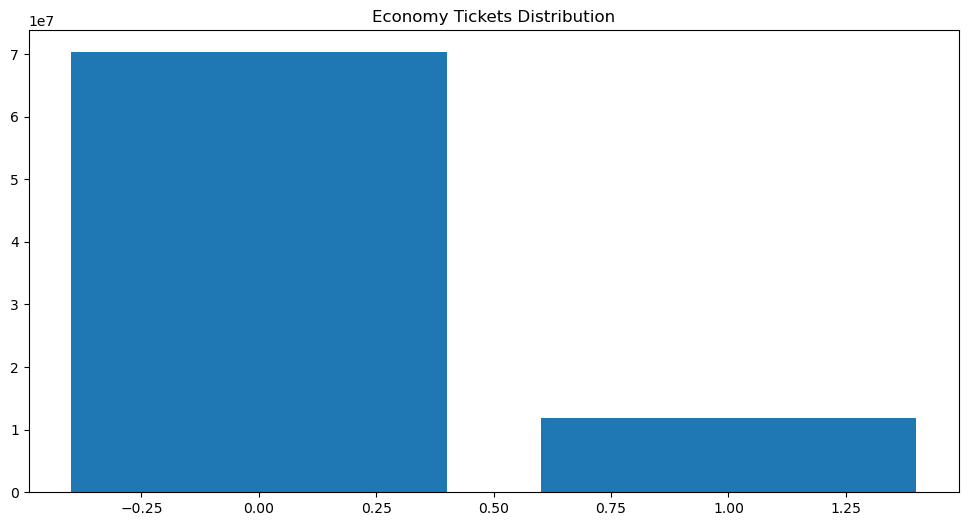

In [28]:
result_df = (price_df.groupBy('is_basic_economy')
                     .count()
                     .orderBy('count', ascending=False)
                     .toPandas())

plt.figure(figsize=(12, 6))
plt.bar(result_df['is_basic_economy'], result_df['count'])
plt.title('Economy Tickets Distribution')
plt.xticks(rotation=0)
plt.show()

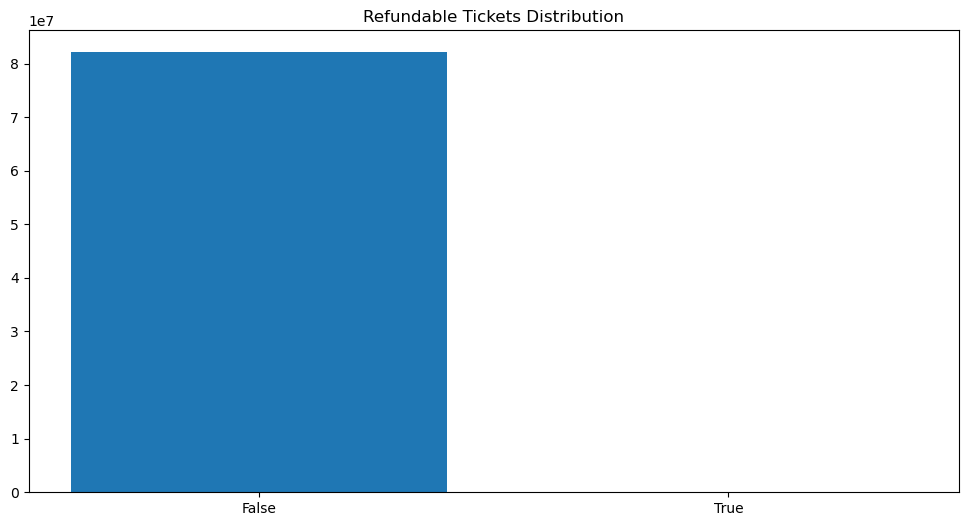

In [29]:
result_df = (price_df.groupBy('is_refundable')
                     .count()
                     .orderBy('count', ascending=False)
                     .toPandas())

plt.figure(figsize=(12, 6))
plt.bar(result_df['is_refundable'].astype(str), result_df['count'])
plt.title('Refundable Tickets Distribution')
plt.xticks(rotation=0)
plt.show()

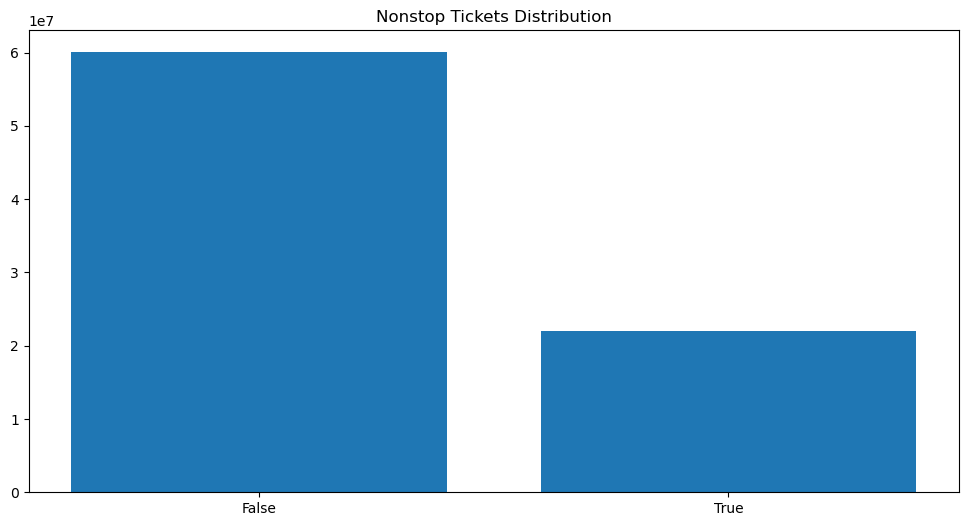

In [30]:
result_df = (price_df.groupBy('is_nonstop')
                     .count()
                     .orderBy('count', ascending=False)
                     .toPandas())

plt.figure(figsize=(12, 6))
plt.bar(result_df['is_nonstop'].astype(str), result_df['count'])
plt.title('Nonstop Tickets Distribution')
plt.xticks(rotation=0)
plt.show()

In [31]:
result_df = (price_df.groupBy('fare_basis_code')
                     .count()
                     .orderBy('count', ascending = False)
                     .toPandas())

top_values = result_df.head(5)
print("Top Values:")
print(top_values)

bottom_values = result_df.tail(5)
print("\nBottom Values:")
print(bottom_values)

Top Values:
  fare_basis_code    count
0        QAA0OKEN  1386708
1        KAUOA0MQ   937054
2        V7AWZNN1   797407
3        QAA0OFEN   570653
4        HAA0OKEN   537424

Bottom Values:
      fare_basis_code  count
21018        WAA7ACBS      1
21019        PL7QUOY5      1
21020        EAU4AKIS      1
21021        H3AZZNC1      1
21022        V0AKZNR3      1


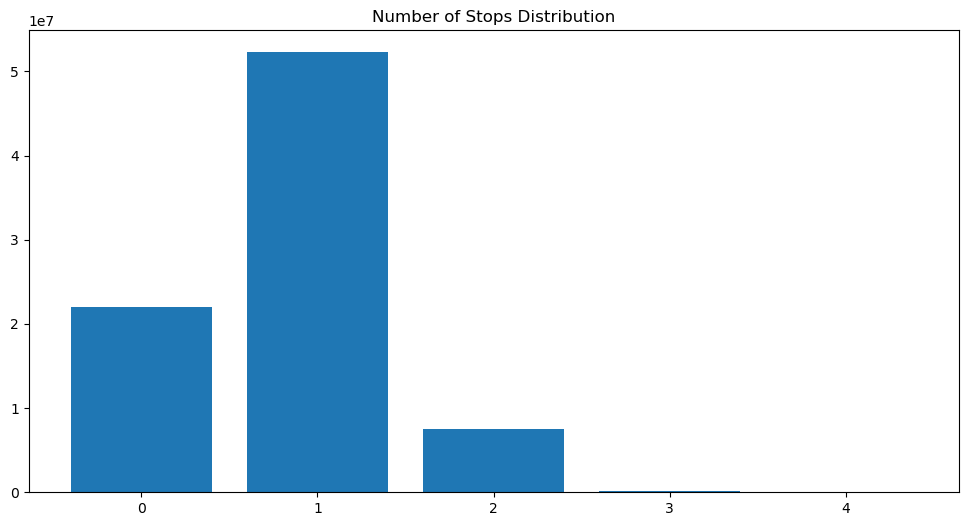

In [32]:
result_df = (price_df.groupBy('num_stops')
                     .count()
                     .orderBy('num_stops')
                     .toPandas())

plt.figure(figsize=(12, 6))
plt.bar(result_df['num_stops'], result_df['count'])
plt.title('Number of Stops Distribution')
plt.xticks(rotation=0)
plt.show()

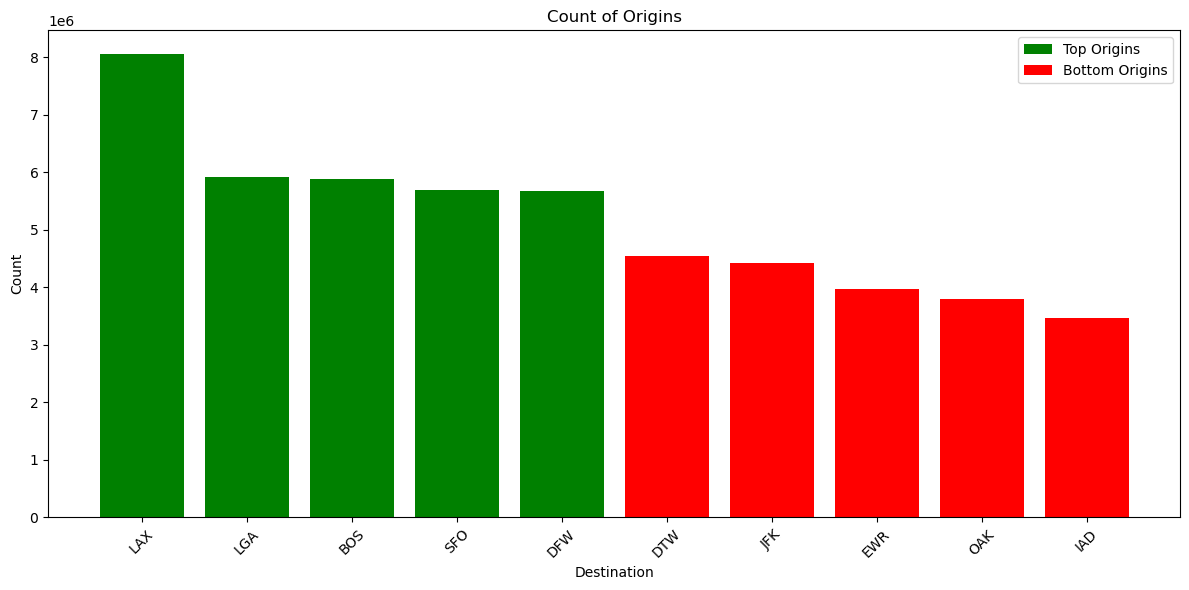

In [33]:
result_df = (price_df.groupBy('origin')
                     .count()
                     .orderBy('count', ascending=False)
                     .toPandas())

top_values = result_df.head(5)
bottom_values = result_df.tail(5)

plt.figure(figsize=(12, 6))
plt.bar(top_values['origin'], top_values['count'], color='green', label='Top Origins')
plt.bar(bottom_values['origin'], bottom_values['count'], color='red', label='Bottom Origins')
plt.title('Count of Origins')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

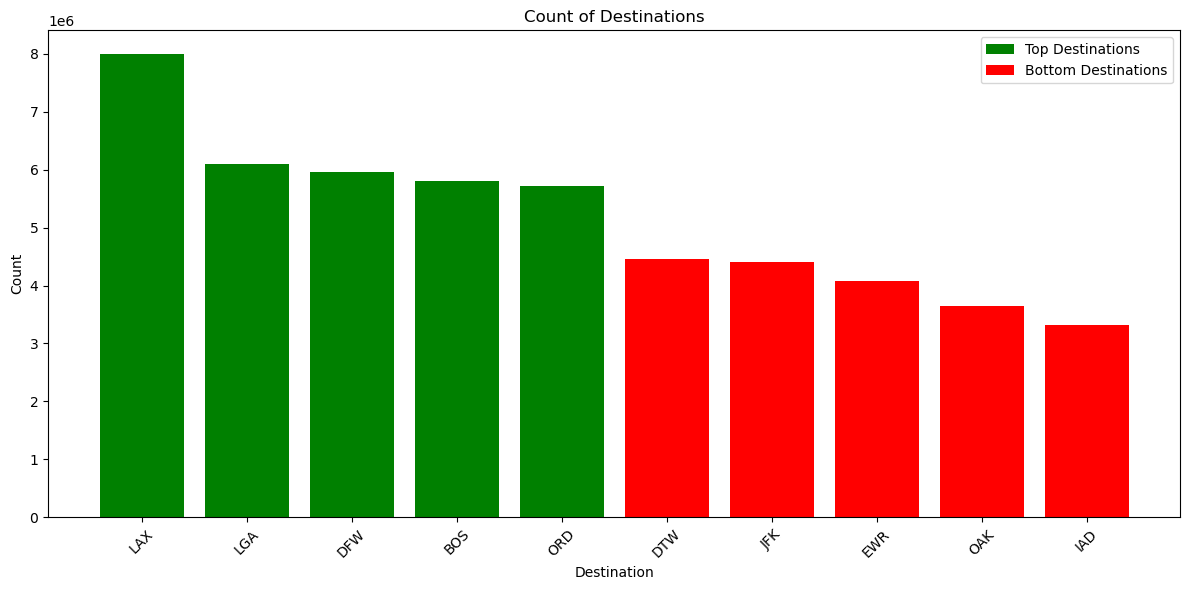

In [34]:
result_df = (price_df.groupBy('destination')
                     .count()
                     .orderBy('count', ascending=False)
                     .toPandas())

top_values = result_df.head(5)
bottom_values = result_df.tail(5)

plt.figure(figsize=(12, 6))
plt.bar(top_values['destination'], top_values['count'], color='green', label='Top Destinations')
plt.bar(bottom_values['destination'], bottom_values['count'], color='red', label='Bottom Destinations')
plt.title('Count of Destinations')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

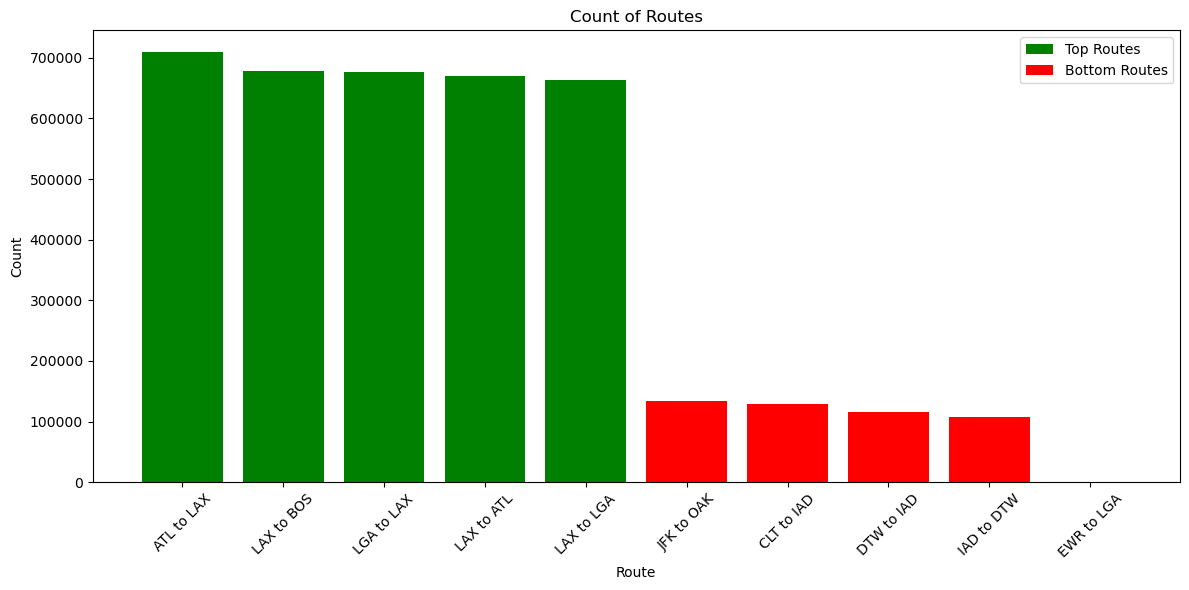

In [35]:
result_df = (price_df.groupBy("origin", "destination")
                     .agg(count("*").alias("route_count"))
                     .orderBy("route_count", ascending=False)
                     .toPandas())

result_df['route'] = result_df['origin'] + ' to ' + result_df['destination']

top_values = result_df.head(5)
bottom_values = result_df.tail(5)

plt.figure(figsize=(12, 6))
plt.bar(top_values['route'], top_values['route_count'], color='green', label='Top Routes')
plt.bar(bottom_values['route'], bottom_values['route_count'], color='red', label='Bottom Routes')
plt.title('Count of Routes')
plt.xlabel('Route')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

**Time Overview:**
* What is the time range? 
* What is the distribution of years, months, and days?
* What is the distribution of hours and minutes for departures and arrivals?

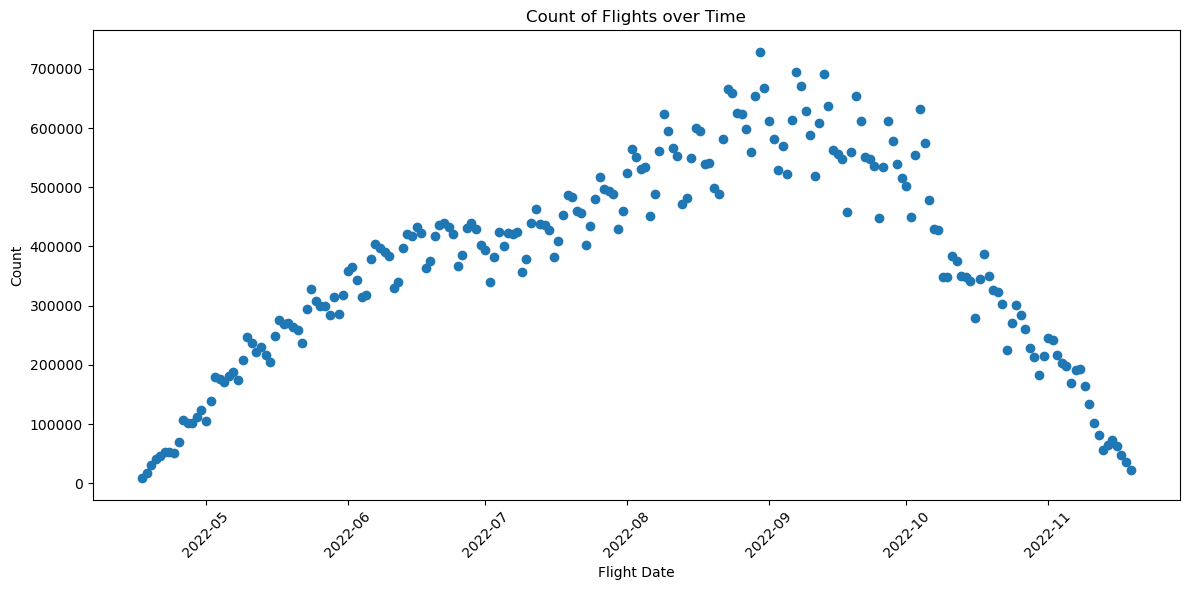

In [36]:
result_df = (price_df.groupBy('flight_date')
                     .count()
                     .orderBy('flight_date')
                     .toPandas())

plt.figure(figsize=(12, 6))
plt.scatter(result_df['flight_date'], result_df['count'])
plt.title('Count of Flights over Time')
plt.xlabel('Flight Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1000x500 with 0 Axes>

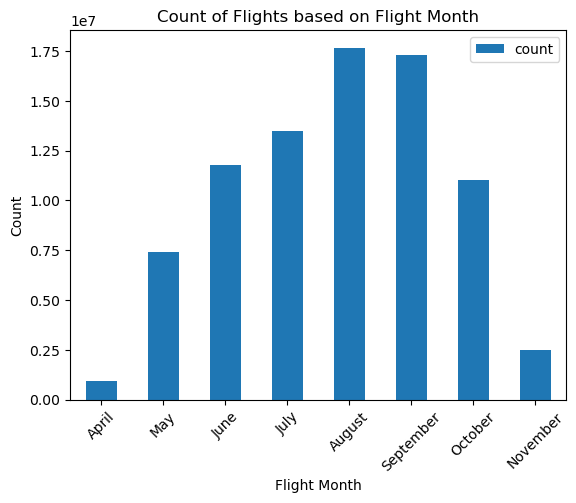

In [37]:
result_df = (price_df.groupBy('flight_month')
                     .count()
                     .orderBy('flight_month')
                     .toPandas())

result_df['month_name'] = result_df['flight_month'].apply(lambda x: calendar.month_name[x])

plt.figure(figsize=(10, 5))
result_df.plot(x='month_name', y='count', kind='bar')
plt.title('Count of Flights based on Flight Month')
plt.xlabel('Flight Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

<Figure size 1000x500 with 0 Axes>

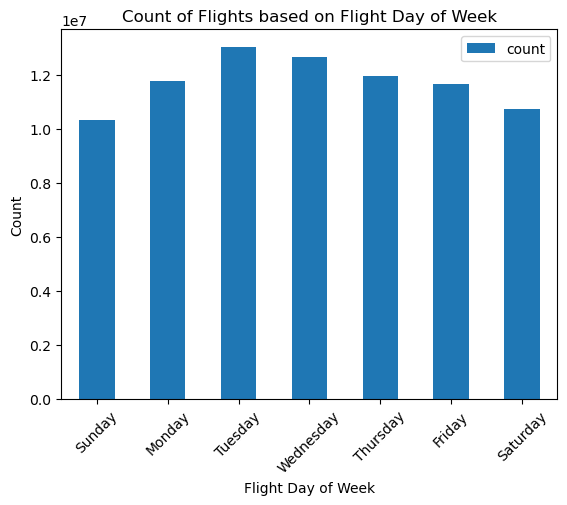

In [38]:
result_df = (price_df.groupBy('day_of_week', 'day_of_week_index')
                     .count()
                     .orderBy('day_of_week_index')
                     .toPandas())

plt.figure(figsize=(10, 5))
result_df.plot(x='day_of_week', y='count', kind='bar')
plt.title('Count of Flights based on Flight Day of Week')
plt.xlabel('Flight Day of Week')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

<Figure size 1000x500 with 0 Axes>

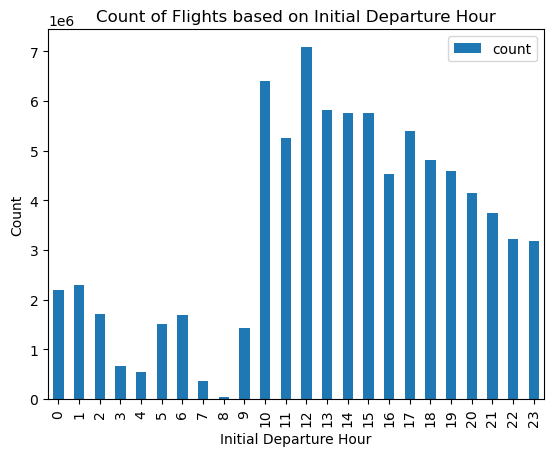

In [39]:
result_df = (price_df.groupBy('initial_departure_hour')
                     .count()
                     .orderBy('initial_departure_hour')
                     .toPandas())

plt.figure(figsize=(10, 5))
result_df.plot(x='initial_departure_hour', y='count', kind='bar')
plt.title('Count of Flights based on Initial Departure Hour')
plt.xlabel('Initial Departure Hour')
plt.ylabel('Count')
plt.show()

In [40]:
result_df = (price_df.groupBy('initial_departure_hour', 'initial_departure_minute')
                     .count()
                     .orderBy('count', ascending=False)
                     .toPandas())

result_df['combined_time'] = result_df['initial_departure_hour'].astype(str) + ':' + result_df['initial_departure_minute'].astype(str)

top_values = result_df.head(5)
print("Top Values:")
print(top_values)

bottom_values = result_df.tail(5)
print("\nBottom Values:")
print(bottom_values)

Top Values:
   initial_departure_hour  initial_departure_minute    count combined_time
0                      10                         0  2338778          10:0
1                      13                         0  1710355          13:0
2                      11                         0  1480043          11:0
3                      12                         0  1411556          12:0
4                      14                         0  1176293          14:0

Bottom Values:
      initial_departure_hour  initial_departure_minute  count combined_time
1357                       4                        56     17          4:56
1358                       7                        29     12          7:29
1359                       9                         4     10           9:4
1360                       7                        14     10          7:14
1361                       3                        53      8          3:53


<Figure size 1000x500 with 0 Axes>

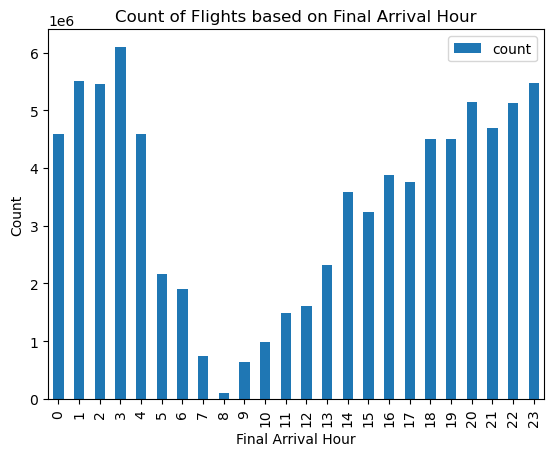

In [41]:
result_df = (price_df.groupBy('final_arrival_hour')
                     .count()
                     .orderBy('final_arrival_hour')
                     .toPandas())

plt.figure(figsize=(10, 5))
result_df.plot(x='final_arrival_hour', y='count', kind='bar')
plt.title('Count of Flights based on Final Arrival Hour')
plt.xlabel('Final Arrival Hour')
plt.ylabel('Count')
plt.show()

In [42]:
result_df = (price_df.groupBy('final_arrival_hour', 'final_arrival_minute')
                     .count()
                     .orderBy('count', ascending=False)
                     .toPandas())

result_df['combined_time'] = result_df['final_arrival_hour'].astype(str) + ':' + result_df['final_arrival_minute'].astype(str)

top_values = result_df.head(5)
print("Top Values:")
print(top_values)

bottom_values = result_df.tail(5)
print("\nBottom Values:")
print(bottom_values)

Top Values:
   final_arrival_hour  final_arrival_minute   count combined_time
0                   3                    59  457544          3:59
1                   5                    21  376034          5:21
2                   1                     5  342956           1:5
3                   3                    30  335655          3:30
4                  20                    50  281064         20:50

Bottom Values:
      final_arrival_hour  final_arrival_minute  count combined_time
1430                   8                     4     13           8:4
1431                   8                    53     10          8:53
1432                   8                    22      8          8:22
1433                   7                    49      6          7:49
1434                   8                    34      5          8:34


**Fare Analysis**:
* How are base and total fares distributed in the dataset?
* What are the most and least expensive total travel duration times?
* Which departure and arrival times correspond to the highest and lowest flight prices?
* Which airports are associated with the highest and lowest expenses for departures and arrivals?
* What routes are considered the most and least expensive for flights?
* Is this the same case when the travel distance is normalized?
* What's the price distribution for refundable tickets? Nonstop? Basic Economy?

In [43]:
base_fare_summary = price_df.agg(
    mean(col("base_fare")).alias("Mean Base Fare"),
    stddev(col("base_fare")).alias("StdDev Base Fare"),
    count(col("base_fare")).alias("Count Base Fare"),
    min(col("base_fare")).alias("Min Base Fare"),
    max(col("base_fare")).alias("Max Base Fare"))

total_fare_summary = price_df.agg(
    mean(col("total_fare")).alias("Mean Total Fare"),
    stddev(col("total_fare")).alias("StdDev Total Fare"),
    count(col("total_fare")).alias("Count Total Fare"),
    min(col("total_fare")).alias("Min Total Fare"),
    max(col("total_fare")).alias("Max Total Fare"))

normalized_fare_summary = price_df.agg(
    mean(col("normalized_fare")).alias("Mean Normalized Fare"),
    stddev(col("normalized_fare")).alias("StdDev Normalized Fare"),
    count(col("normalized_fare")).alias("Count Normalized Fare"),
    min(col("normalized_fare")).alias("Min Normalized Fare"),
    max(col("normalized_fare")).alias("Max Normalized Fare"))

base_fare_summary.show()
total_fare_summary.show()
normalized_fare_summary.show()

+-----------------+------------------+---------------+-------------+-------------+
|   Mean Base Fare|  StdDev Base Fare|Count Base Fare|Min Base Fare|Max Base Fare|
+-----------------+------------------+---------------+-------------+-------------+
|291.6837932989905|177.43803247053896|       82098689|         0.01|      1845.58|
+-----------------+------------------+---------------+-------------+-------------+



+------------------+------------------+----------------+--------------+--------------+
|   Mean Total Fare| StdDev Total Fare|Count Total Fare|Min Total Fare|Max Total Fare|
+------------------+------------------+----------------+--------------+--------------+
|339.33558641395933|189.83328065346004|        82098689|         19.59|        1999.7|
+------------------+------------------+----------------+--------------+--------------+



+--------------------+----------------------+---------------------+-------------------+-------------------+
|Mean Normalized Fare|StdDev Normalized Fare|Count Normalized Fare|Min Normalized Fare|Max Normalized Fare|
+--------------------+----------------------+---------------------+-------------------+-------------------+
|  0.2704586650553764|   0.21090099599833795|             76004535| 0.0170267131242741|  13.17123711340206|
+--------------------+----------------------+---------------------+-------------------+-------------------+



In [44]:
print("Min Base Fare Count: ", price_df.filter(price_df['base_fare'] == 0.01).count())
price_df.filter(price_df['base_fare'] == 0.01).show(3)

Min Base Fare Count:  1320


+-----------+-----------+------+-----------+---------------+---------------+------------+----------------+-------------+----------+---------+----------+---------------+--------------+--------------------+--------------------+--------------------+------------+---------------------+----------+------------+-----------------+-----------+------------+----------+----------------+-------------------+-------------+----------------+-----+-----------+---------------+-----------------------+-----------------------+---------+--------------------------+----------------------+----------------------+------------------------+------------------+--------------------+-----------+-----------------+---------------+
|search_date|flight_date|origin|destination|fare_basis_code|travel_duration|elapsed_days|is_basic_economy|is_refundable|is_nonstop|base_fare|total_fare|seats_remaining|total_distance|      departure_time|        arrival_time|        airline_name|airline_code|equipment_description|  distance|  ca

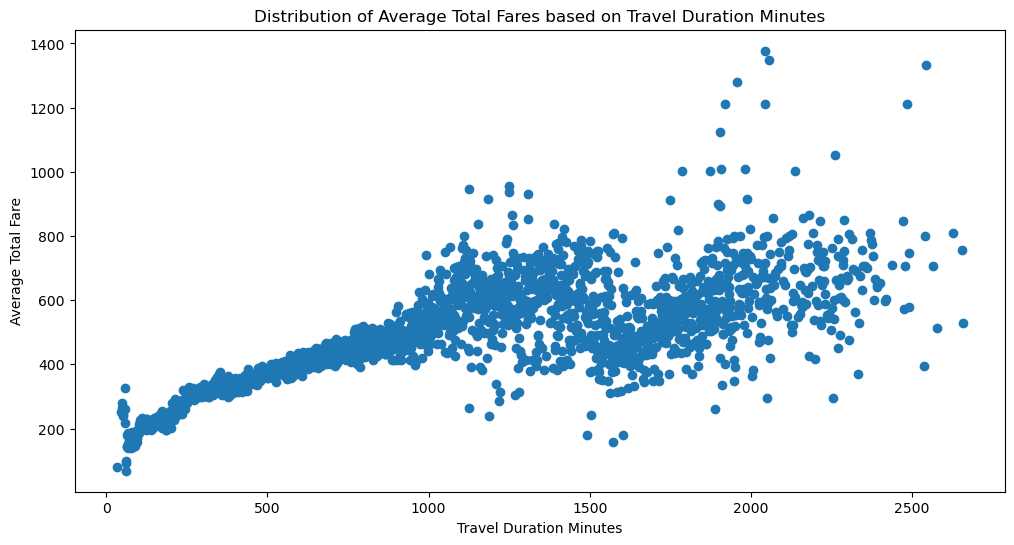

In [45]:
result_df = (price_df.groupBy("travel_duration_minutes")
                     .agg(mean("total_fare").alias("average_total_fare"))
                     .toPandas())

plt.figure(figsize=(12, 6))
plt.scatter(result_df['travel_duration_minutes'], result_df['average_total_fare'])
plt.title('Distribution of Average Total Fares based on Travel Duration Minutes')
plt.xlabel('Travel Duration Minutes')
plt.ylabel('Average Total Fare')
plt.show()

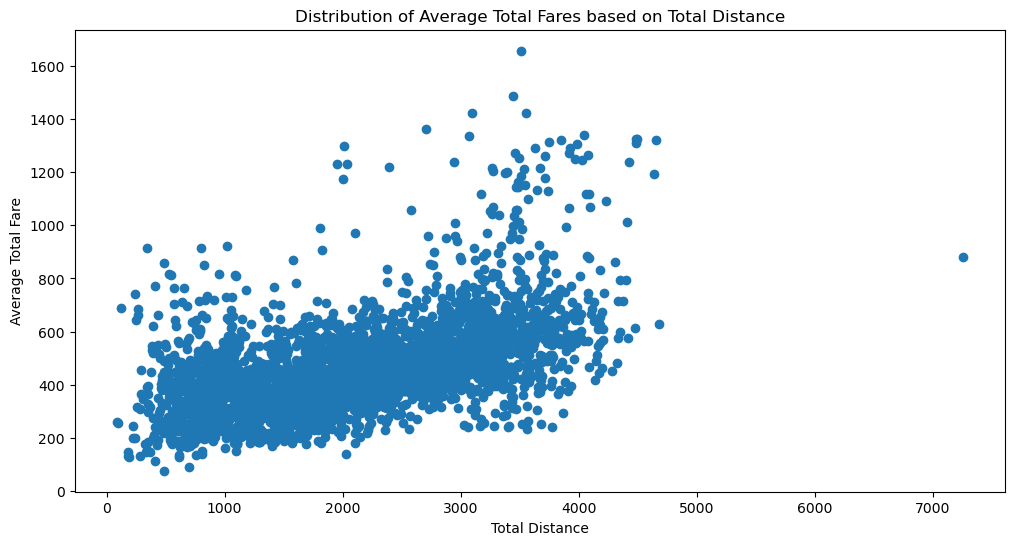

In [46]:
result_df = (price_df.groupBy("total_distance")
                     .agg(mean("total_fare").alias("average_total_fare"))
                     .toPandas())

plt.figure(figsize=(12, 6))
plt.scatter(result_df['total_distance'], result_df['average_total_fare'])
plt.title('Distribution of Average Total Fares based on Total Distance')
plt.xlabel('Total Distance')
plt.ylabel('Average Total Fare')
plt.show()

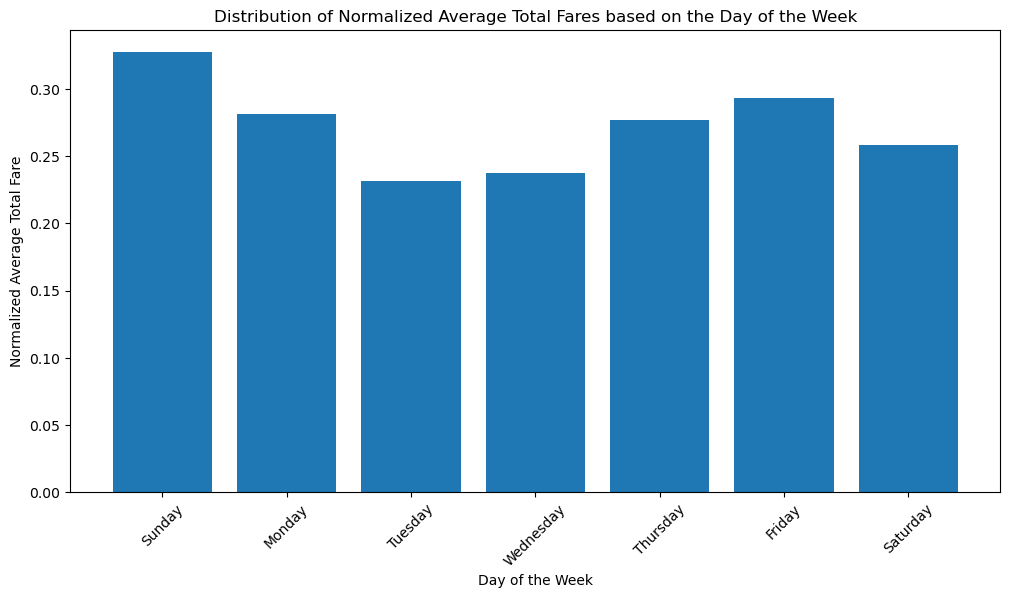

In [47]:
result_df = (price_df.groupBy("day_of_week", "day_of_week_index")
                     .agg(mean("normalized_fare").alias("average_normalized_fare"))
                     .orderBy('day_of_week_index')
                     .toPandas())

plt.figure(figsize=(12, 6))
plt.bar(result_df['day_of_week'], result_df['average_normalized_fare'])
plt.title('Distribution of Normalized Average Total Fares based on the Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Normalized Average Total Fare')
plt.xticks(rotation=45)
plt.show()

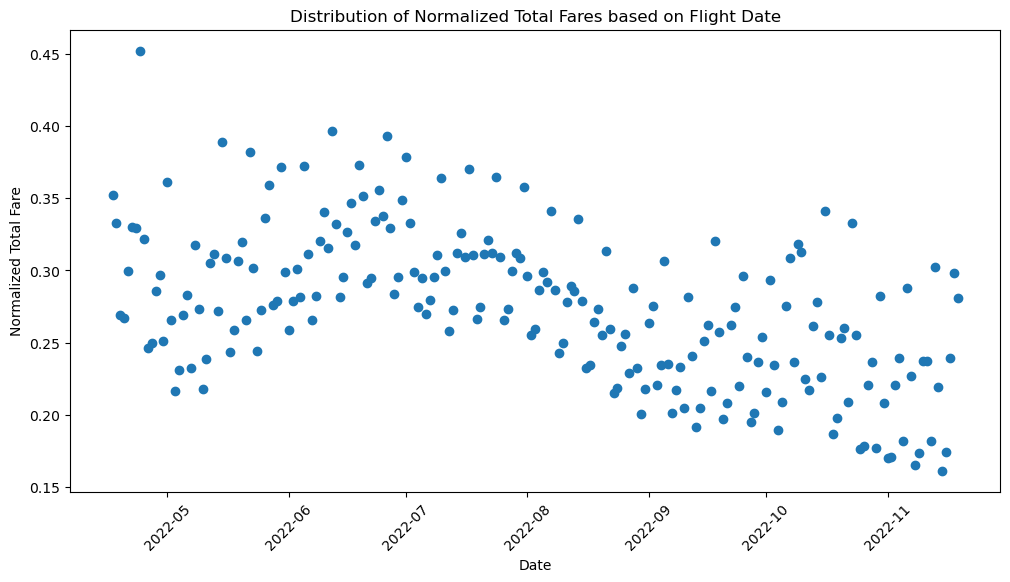

In [48]:
result_df = (price_df.groupBy("flight_date")
                     .agg(mean("normalized_fare").alias("average_normalized_fare"))   
                     .orderBy("flight_date")
                     .toPandas())

plt.figure(figsize=(12, 6))
plt.scatter(result_df['flight_date'], result_df['average_normalized_fare'])
plt.title('Distribution of Normalized Total Fares based on Flight Date')
plt.xlabel('Date')
plt.ylabel('Normalized Total Fare')
plt.xticks(rotation=45)
plt.show()

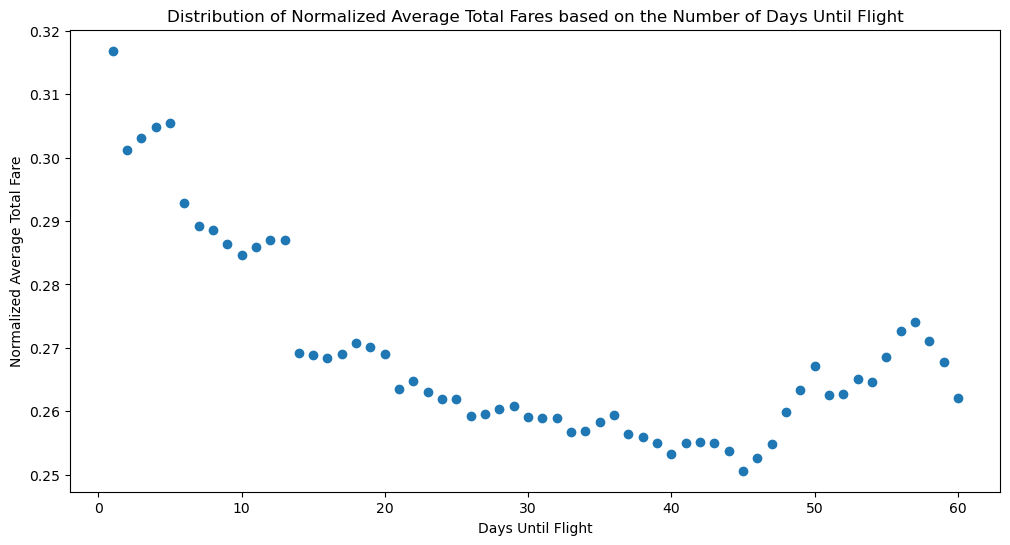

In [49]:
result_df = (price_df.groupBy("days_until_flight")
                     .agg(mean("normalized_fare").alias("average_normalized_fare"))
                     .orderBy("days_until_flight")
                     .toPandas())

plt.figure(figsize=(12, 6))
plt.scatter(result_df['days_until_flight'], result_df['average_normalized_fare'])
plt.title('Distribution of Normalized Average Total Fares based on the Number of Days Until Flight')
plt.xlabel('Days Until Flight')
plt.ylabel('Normalized Average Total Fare')
plt.show()

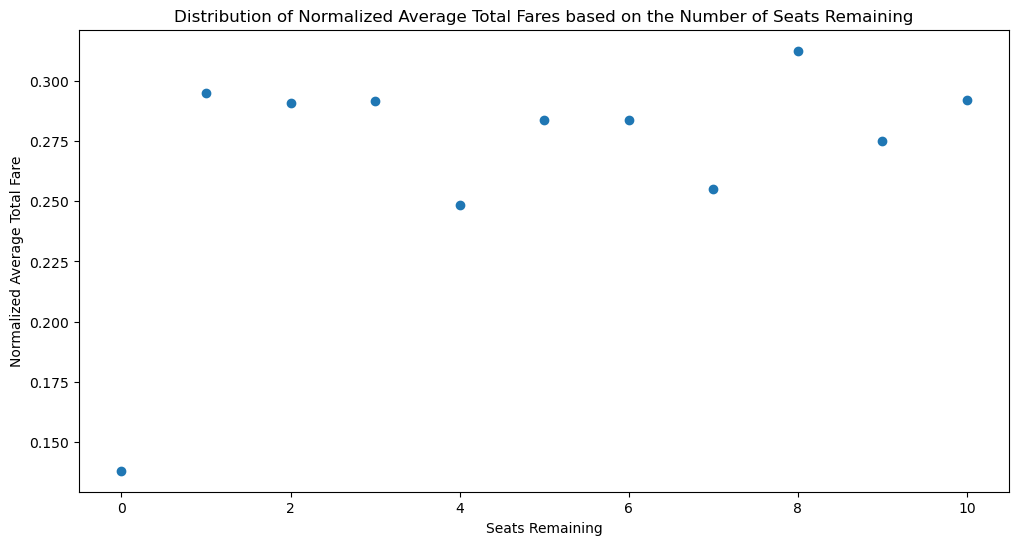

In [50]:
result_df = (price_df.groupBy("seats_remaining")
                     .agg(mean("normalized_fare").alias("average_normalized_fare"))
                     .orderBy("seats_remaining")
                     .toPandas())

plt.figure(figsize=(12, 6))
plt.scatter(result_df['seats_remaining'], result_df['average_normalized_fare'])
plt.title('Distribution of Normalized Average Total Fares based on the Number of Seats Remaining')
plt.xlabel('Seats Remaining')
plt.ylabel('Normalized Average Total Fare')
plt.show()

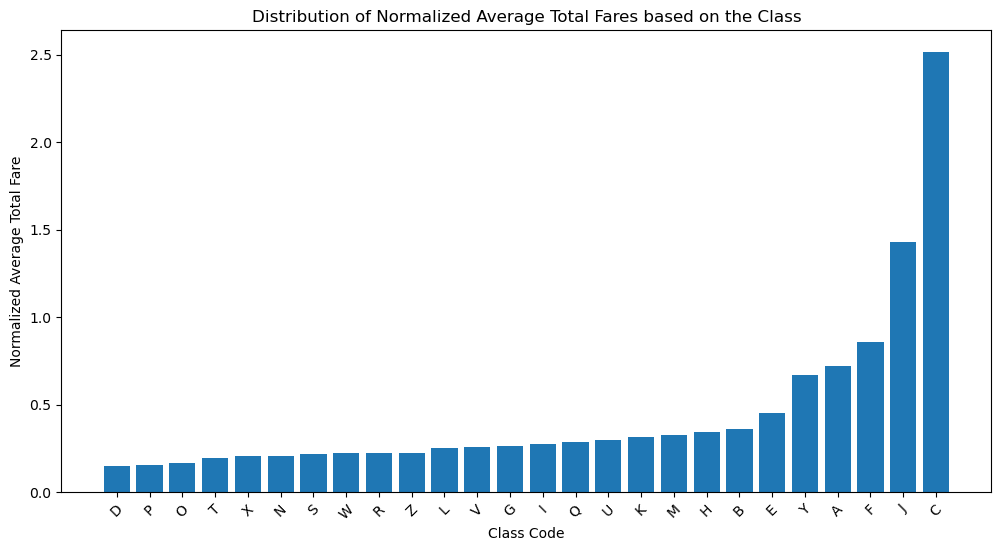

In [51]:
result_df = (price_df.groupBy("class")
                     .agg(mean("normalized_fare").alias("average_normalized_fare"))
                     .orderBy("average_normalized_fare")
                     .toPandas())

plt.figure(figsize=(12, 6))
plt.bar(result_df['class'], result_df['average_normalized_fare'])
plt.title('Distribution of Normalized Average Total Fares based on the Class')
plt.xlabel('Class Code')
plt.ylabel('Normalized Average Total Fare')
plt.xticks(rotation=45)
plt.show()

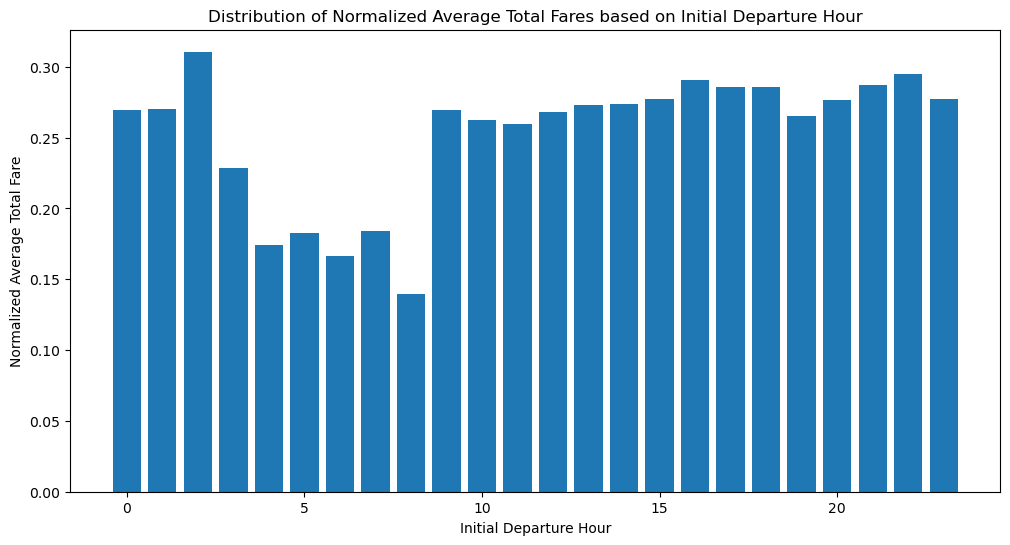

In [52]:
result_df = (price_df.groupBy("initial_departure_hour")
                     .agg(mean("normalized_fare").alias("average_normalized_fare"))
                     .orderBy("initial_departure_hour")
                     .toPandas())

plt.figure(figsize=(12, 6))
plt.bar(result_df['initial_departure_hour'], result_df['average_normalized_fare'])
plt.title('Distribution of Normalized Average Total Fares based on Initial Departure Hour')
plt.xlabel('Initial Departure Hour')
plt.ylabel('Normalized Average Total Fare')
plt.show()

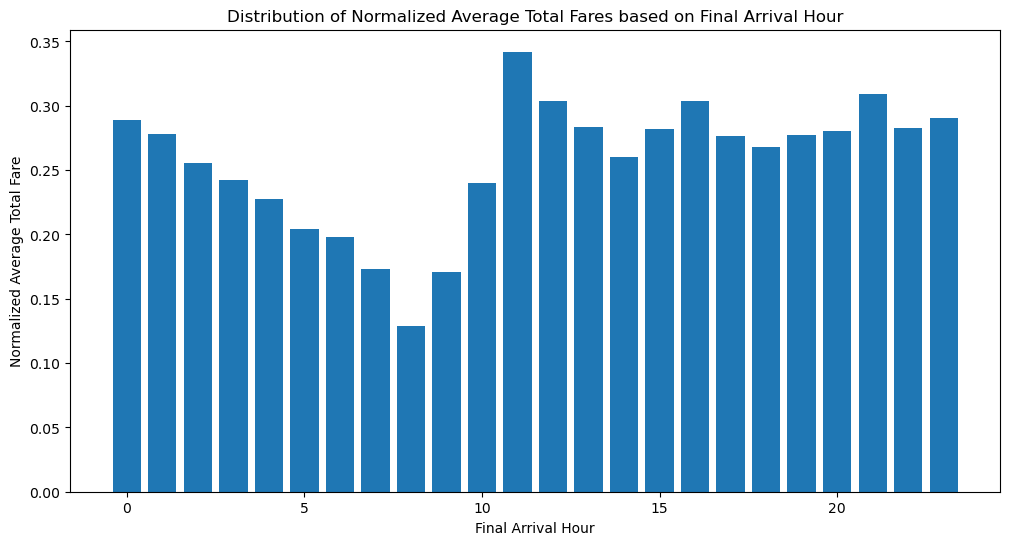

In [53]:
result_df = (price_df.groupBy("final_arrival_hour")
                     .agg(mean("normalized_fare").alias("average_normalized_fare"))
                     .orderBy("final_arrival_hour")
                     .toPandas())

plt.figure(figsize=(12, 6))
plt.bar(result_df['final_arrival_hour'], result_df['average_normalized_fare'])
plt.title('Distribution of Normalized Average Total Fares based on Final Arrival Hour')
plt.xlabel('Final Arrival Hour')
plt.ylabel('Normalized Average Total Fare')
plt.show()

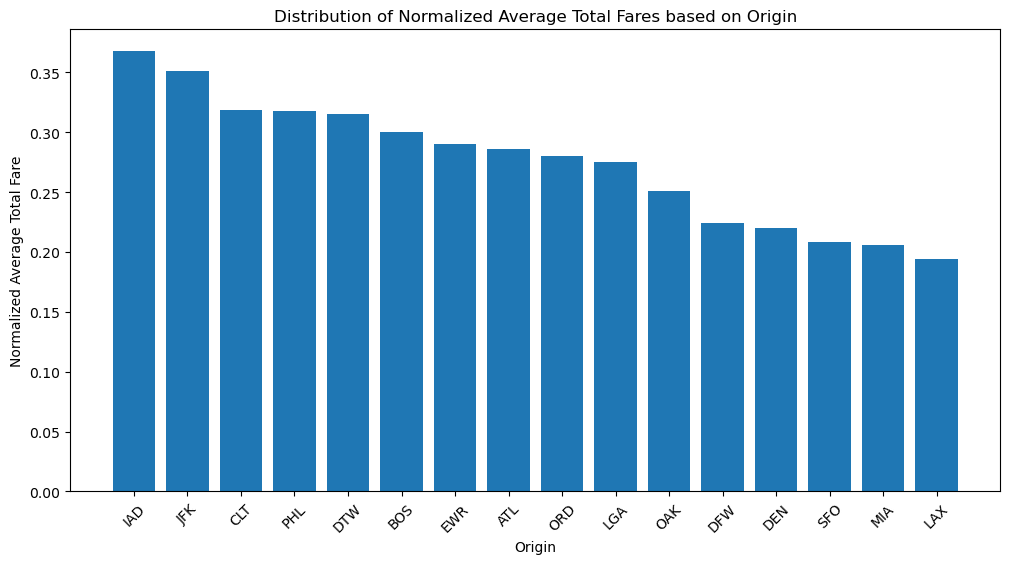

In [54]:
result_df = (price_df.groupBy("origin")
                     .agg(mean("normalized_fare").alias("average_normalized_fare"))
                     .orderBy("average_normalized_fare", ascending=False)
                     .toPandas())

plt.figure(figsize=(12, 6))
plt.bar(result_df['origin'], result_df['average_normalized_fare'])
plt.title('Distribution of Normalized Average Total Fares based on Origin')
plt.xlabel('Origin')
plt.ylabel('Normalized Average Total Fare')
plt.xticks(rotation=45)
plt.show()

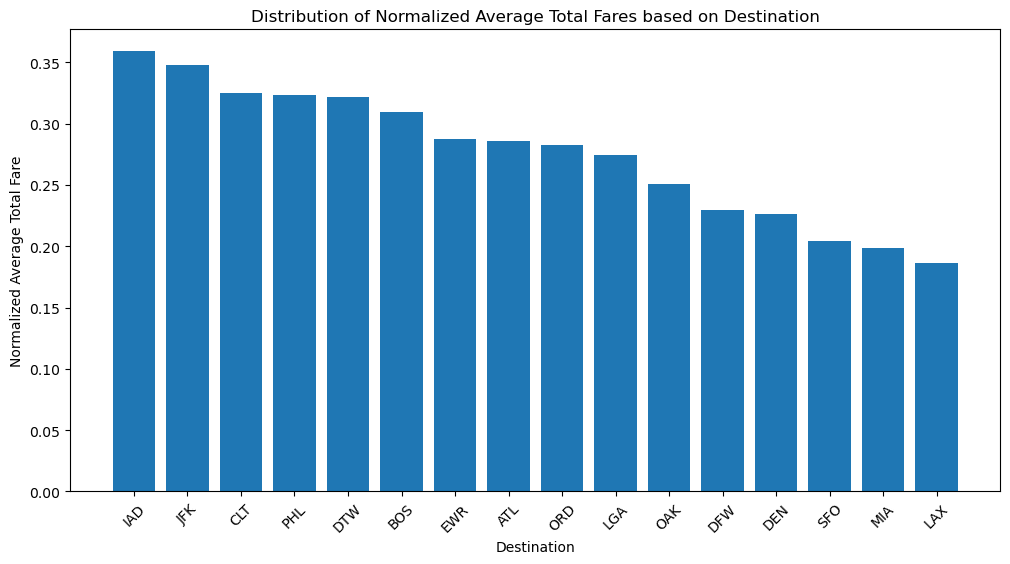

In [55]:
result_df = (price_df.groupBy("destination")
                     .agg(mean("normalized_fare").alias("average_normalized_fare"))
                     .orderBy("average_normalized_fare", ascending=False)
                     .toPandas())

plt.figure(figsize=(12, 6))
plt.bar(result_df['destination'], result_df['average_normalized_fare'])
plt.title('Distribution of Normalized Average Total Fares based on Destination')
plt.xlabel('Destination')
plt.ylabel('Normalized Average Total Fare')
plt.xticks(rotation=45)
plt.show()

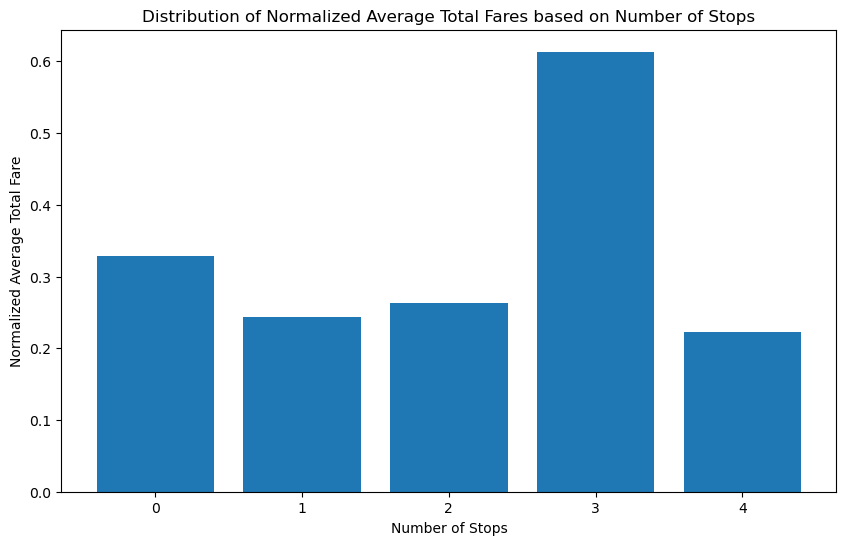

In [56]:
result_df = (price_df.groupBy("num_stops")
                     .agg(mean("normalized_fare").alias("average_normalized_fare"))
                     .orderBy("num_stops")
                     .toPandas())

plt.figure(figsize=(10, 6))
plt.bar(result_df['num_stops'].astype(str), result_df['average_normalized_fare'])
plt.title('Distribution of Normalized Average Total Fares based on Number of Stops')
plt.xlabel('Number of Stops')
plt.ylabel('Normalized Average Total Fare')
plt.xticks(rotation=0)
plt.show()

Top Values:
  origin destination  average_normalized_fare
0    EWR         LAX                 0.141968
1    MIA         LAX                 0.143700
2    BOS         LAX                 0.145872
3    EWR         SFO                 0.149608
4    DFW         LGA                 0.150285

Bottom Values:
    origin destination  average_normalized_fare
230    ORD         DTW                 0.685754
231    ATL         CLT                 0.701713
232    BOS         JFK                 0.807472
233    EWR         LGA                 0.810193
234    JFK         BOS                 0.830640


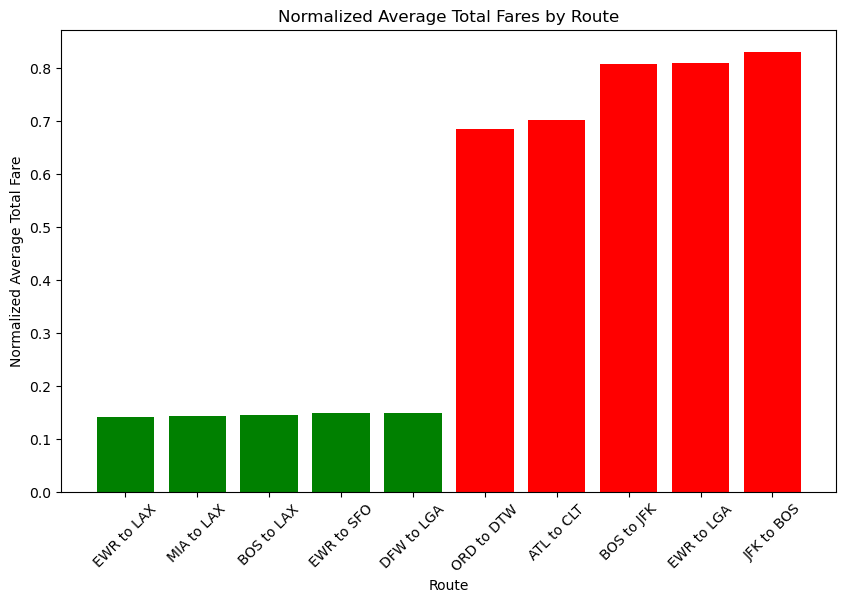

In [57]:
result_df = (price_df.groupBy("origin", "destination")
                     .agg(mean("normalized_fare").alias("average_normalized_fare"))
                     .orderBy("average_normalized_fare")
                     .toPandas())

top_values = result_df.head(5)
print("Top Values:")
print(top_values)

bottom_values = result_df.tail(5)
print("\nBottom Values:")
print(bottom_values)

plt.figure(figsize=(10, 6))
plt.bar(top_values['origin'] + ' to ' + top_values['destination'], 
        top_values['average_normalized_fare'], 
        color='green', 
        label='Top Normalized Average Total Fares')
plt.bar(bottom_values['origin'] + ' to ' + bottom_values['destination'], 
        bottom_values['average_normalized_fare'], 
        color='red', 
        label='Bottom Normalized Average Total Fares')
plt.title('Normalized Average Total Fares by Route')
plt.xlabel('Route')
plt.ylabel('Normalized Average Total Fare')
plt.xticks(rotation=45)
plt.show()

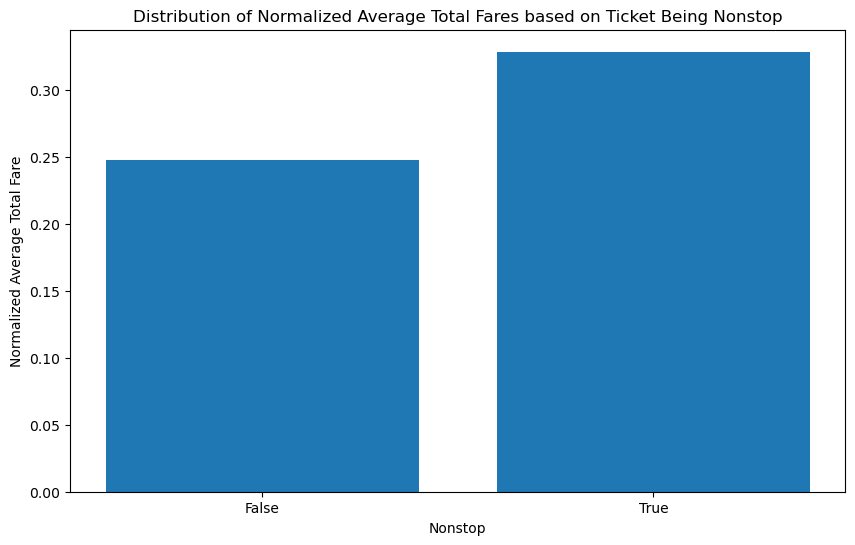

In [58]:
result_df = (price_df.groupBy("is_nonstop")
                     .agg(mean("normalized_fare").alias("average_normalized_fare"))
                     .orderBy("is_nonstop")
                     .toPandas())
plt.figure(figsize=(10, 6))
plt.bar(result_df['is_nonstop'].astype(str), result_df['average_normalized_fare'])
plt.title('Distribution of Normalized Average Total Fares based on Ticket Being Nonstop')
plt.xlabel('Nonstop')
plt.ylabel('Normalized Average Total Fare')
plt.xticks(rotation=0)
plt.show()

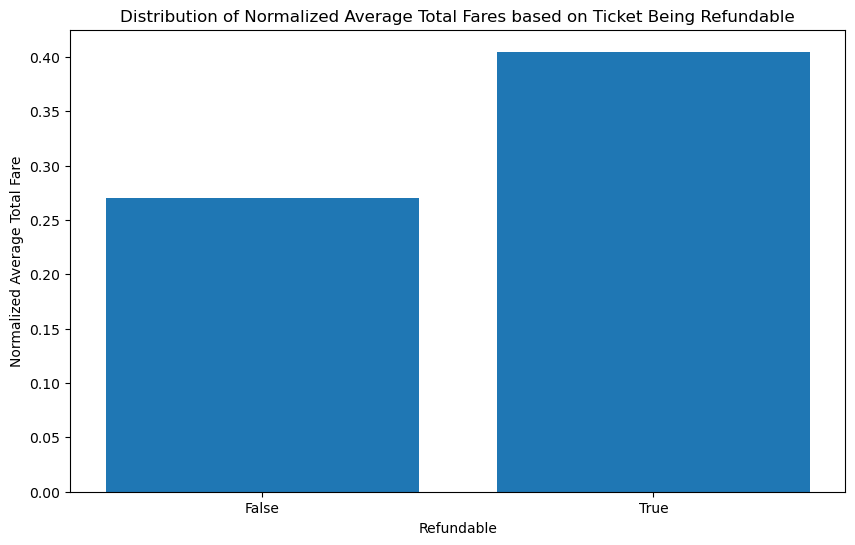

In [59]:
result_df = (price_df.groupBy("is_refundable")
                     .agg(mean("normalized_fare").alias("average_normalized_fare"))
                     .orderBy("is_refundable")
                     .toPandas())

plt.figure(figsize=(10, 6))
plt.bar(result_df['is_refundable'].astype(str), result_df['average_normalized_fare'])
plt.title('Distribution of Normalized Average Total Fares based on Ticket Being Refundable')
plt.xlabel('Refundable')
plt.ylabel('Normalized Average Total Fare')
plt.xticks(rotation=0)
plt.show()

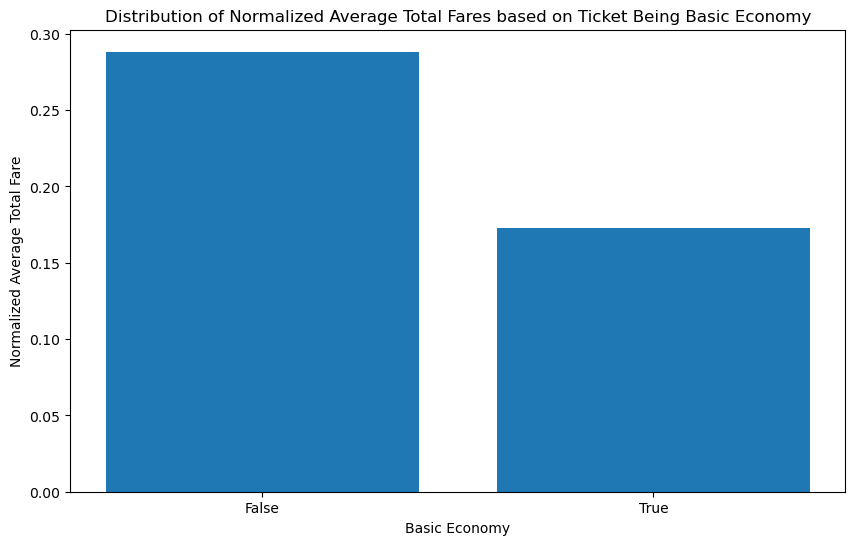

In [60]:
result_df = (price_df.groupBy("is_basic_economy")
                     .agg(mean("normalized_fare").alias("average_normalized_fare"))
                     .orderBy("is_basic_economy")
                     .toPandas())

plt.figure(figsize=(10, 6))
plt.bar(result_df['is_basic_economy'].astype(str), result_df['average_normalized_fare'])
plt.title('Distribution of Normalized Average Total Fares based on Ticket Being Basic Economy')
plt.xlabel('Basic Economy')
plt.ylabel('Normalized Average Total Fare')
plt.xticks(rotation=0)
plt.show()